<center>

<h1> Mutable(?) data structures </h1>
</center>

## Review

### Previously

* Application of Prolog: Type inference and Program Synthesis in Lambda Calculus

### This lecture

* Simulating mutable data structures in Prolog.
* Difference lists: a logic programming technique.

## Variables in terms

So far all of our uses of variables have been in queries or clauses, but not in terms representing objects. Consider:
```
?- L = [1,2 | X]
L = [1, 2|X].
```
is a **open** list which has a prefix of `[1,2]`.

We can extend the list `L` by unifying `X` with something else.

```
?- L = [1,2 | X], X = [3 | Y]
L = [1, 2, 3|Y],
X = [3|Y].
```

Such lists are said to be **open lists**.

## Jupyter + Prolog fail!

Jupyter + Prolog is a solution in development (read as does not work as intended).

In [1]:
?- L = [1,2 | X].

L = [ 1, 2 ], X = _1596 .

The result should have been `L = [ 1, 2 | X] .`.

We will use the SWI-Prolog interpreter directly for this lecture.

## Queues

We will use open lists to represent queues.

* A queue is represented by `q(L,E)`, where 
  + `L` is an open list
  + `E` is some suffix of L.
* The contents of the queue are the elements in `L` that are not in `E`.
  + `q([1,2,3],[3])` has elements `1` and `2`.

## Enter and Leave

We will use predicates `enter` and `leave` to capture elements entering and leaving the queue.

* `enter(a,Q,R)`: when an element `a` enters the queue `Q`, we get the queue `R`.
* `leave(a,Q,R)`: when an element `a` leaves the queue `Q`, we get the queue `R`.

## Implementing the queues

```
setup(q(X,X)).
leave(A, q(X,Z), q(Y,Z)) :- X = [A | Y].
enter(A, q(X,Y), q(X,Z)) :- Y = [A | Z].
wrapup(q([],[])).
```


`enter` is a bit strange. Let's try:

```prolog
?- setup(Q), enter(0,Q,R).
Q = q([0|_9530], [0|_9530]),
R = q([0|_9530], _9530).
```


* Quite a strange behaviour: Remove `0` from the suffix of `Q`!
  + But as a result, the queue `R` has one element `0`.

## Implementing Queues

```
leave(A, q(X,Z), q(Y,Z)) :- X = [A | Y].
```

while leave removes an element from the prefix. 

```
enter(A, q(X,Y), q(X,Z)) :- Y = [A | Z].
```

enter removes an element from the suffix!

## Working with the queues

```
?- setup(Q), enter(a,Q,R), enter(b,R,S), 
   leave(X,S,T), leave(Y,T,U), wrapup(U).
Q = q([a, b], [a, b]),
R = q([a, b], [b]),
S = q([a, b], []),
X = a,
T = q([b], []),
Y = b,
U = q([], []).
```

## Quiz 1

Given 

```
?- setup(Q), enter(a,Q,R), enter(b,R,S), 
   leave(X,S,T), leave(Y,T,U), wrapup(U).
Q = q([a, b], [a, b]),
R = q([a, b], [b]),
S = q([a, b], []),
X = a,
T = q([b], []),
Y = b,
U = q([], []).
```

What are the lengths of Q, R, S, T, U?

## Quiz 1

Given 

```
?- setup(Q), enter(a,Q,R), enter(b,R,S), 
   leave(X,S,T), leave(Y,T,U), wrapup(U).
Q = q([a, b], [a, b]),
R = q([a, b], [b]),
S = q([a, b], []),
X = a,
T = q([b], []),
Y = b,
U = q([], []).
```

What are the lengths of Q, R, S, T, U? **0, 1, 2, 1, 0**.

## Deficit queues

Interestingly, the implementation also works where arbitrary elements are first popped and then unified with elements pushed later.

```
?- setup(Q), leave(X,Q,R), leave(Y,R,S), 
   enter(a,S,T), enter(b,T,U), wrapup(U).
Q = q([a, b], [a, b]),
X = a,
R = q([b], [a, b]),
Y = b,
S = q([], [a, b]),
T = q([], [b]),
U = q([], []).
```

## Quiz 2

What is the result of this query?

```
?- setup(Q), leave(a,Q,R), wrapup(R).
```

1. false.
2. true with some assignments for variables.

## Quiz 2

What is the result of this query?

```
?- setup(Q), leave(a,Q,R), wrapup(R).
```

1. false. **✓**
2. true with some assignments for variables.

## Simplifying the queue implementation

```
enter(A, q(X,Y), q(X,Z)) :- Y = [A | Z].
leave(A, q(X,Z), q(Y,Z)) :- X = [A | Y].
```

can be simplified to

```
enter(A, q(X,[A | Z]), q(X,Z)).
leave(A, q([A | Y],Z), q(Y,Z)).
```

by pushing the unification into the head of the rule to make it a fact.

## Implementing Stack



```
setup(s([])).
leave(A, s(X), s(Y)) :- X = [A | Y].
enter(A, s(X), s(Y)) :- Y = [A | X].
```


## Motivating Difference Lists

Recall the definition of `append` on regular lists

In [ ]:
append([],Q,Q).
append([H | P], Q, [H | R]) :- append(P,Q,R).

It is easy to see that this `append` is `O(N)` operation, where `N` is the length of the first list. 

Can we get `O(1)` append?

## Motivating Difference Lists

Given two lists `L1 = [1,2,3]` and `L2 = [4,5,6]`, the result of appending them is `X` such that:

```
append(L1,L2,X)
where
L1 = [1,2,3 | []]
L2 = [4,5,6 | []]
```

Instead of having `[]` as the tail, what if we had a variable.

## Motivating Difference Lists

```
append(L1,L2,X)
where
L1 = [1,2,3 | A]
L2 = [4,5,6 | B]
```

* Then, append is really unifying `A` and `L2` to derive the result list `X = [1,2,3,4,5,6 | B]`.
* Now, `append` becomes an `O(1)` operation.
* Such a list representation is known as a **difference list**.

## Reimplementing Append
```          
      L1         S1
      ↓          ↓
      +----------+------+

```
Similar to queues, the content of each list is the list of all elements in `L1` not in `S1`

Hence the name difference list.

Example: The list `[1,2,3]` can expressed as the difference of `[1,2,3,4,5]` and `[4,5]`, or `[1,2,3]` and `[]`. 
In general, any open list `[1,2,3|X]` and `X`.


## Reimplementing Append
```          
           S1
           ↓
   L1 +----+------------+
                  S2
                  ↓
   L2      +------+-----+
    
   L3 +----+------+-----+
                  ↑ 
                  S3
```
```
append(L1,S1,L2,S2,L3,S3) :- S1 = L2, L3 = L1, S3 = S2.
```

Pushing the unification into the head of the rule, we get

```
append(L1,L2,L2,S2,L1,S2).
```

Renaming the variables, we get.

```
append(A,B,B,C,A,C).
```

## Convenient notation for difference lists

* We can introduce an infix function symbol `-` to represent difference lists.
  + `A-B` represents a difference list with list `A` with some suffix `B`.
* Whenever you see `A-B`, you should imagine `[...|B]-B`.

Rewriting the append rule

```
append(A-B,B-C,A-C).
```

```
?- append([a,b,c|B]-B,[1,2]-[],A-C).
B = [1, 2],
A = [a, b, c, 1, 2],
C = [].
```

## Quiz

How should you represent an empty difference list?

1. []
2. []-[]
3. A-A
4. [A]

## Quiz

How should you represent an empty difference list?

1. []
2. []-[]
3. A-A **✓**
4. [A]

## Empty difference list representation

```
append(A-B,B-C,A-C)
```

Consider appending onto an empty difference list. 

With the empty list represented using `A-A`, we get

```
append(A-A,[1,2,3|C]-C,A-C)
```

The unifications we get is `A = [1,2,3|C]`. Hence the result is just `[1,2,3|C]-C`, which is what we want. 

## Empty difference list representation

```
append(A-B,B-C,A-C)
```

However, with the empty list represented using `[]-[]`, we get

```
append([]-[],[1,2,3|C]-C,A-C)
```

which fails to unify since `[]` does not unify with `[1,2,3|C]`.

It appears that the correct way to encode an empty difference list is `A-A`. 

But this can cause problems sometimes.

## Unification issues with empty difference list

Consider unifying _empty_ list with _non-empty_ one. 

```
A-A = [1,2,3|B]-B
```

They shouldn't unify.

## Unification issues with empty difference list

```
A-A = [1,2,3|B]-B
```
However, the second term on LHS, `A` unifies with `B` on RHS. So we get,

```
A-A = [1,2,3|A]-A
```

Now, unifying `A` with `[1,2,3|A]`, makes `A` an infinite term `[1,2,3 | [1,2,3 | [1,2,3 [...]]]]`.

This is due to the default lack of **occurs check** before unification in prolog.

Better to set `?- set_prolog_flag(occurs_check, error).`

## Improving quicksort using difference list

Let's try to improve the efficiency of quicksort using difference lists.

```prolog
partition([],Y,[],[]).
partition([X|Xs],Y,[X|Ls],Rs) :- X =< Y, partition(Xs,Y,Ls,Rs).
partition([X|Xs],Y,Ls,[X|Rs]) :- X > Y, partition(Xs,Y,Ls,Rs).

quicksort([H|T],SL) :-
  partition(T,H,Ls,Rs),
  quicksort(Ls,SLs),
  quicksort(Rs,SRs),
  append(SLs,[H|SRs],SL).
quicksort([],[]).
```

## Improving quicksort using difference list

```prolog
quicksort_dl([H|T],A-C) :-
  partition(T,H,Ls,Rs),
  quicksort_dl(Ls,Al-Bl),
  quicksort_dl(Rs,Ar-Br),
  append(Al-Bl,[H|Ar]-Br,A-C).
quicksort_dl([],A-A).
```

```prolog
?- quicksort_dl([6,5,4,3,2,1,0],A-C).
A = [0, 1, 2, 3, 4, 5, 6|C] ;
```

## Improving quicksort using difference list

```prolog
quicksort_dl([H|T],A-C) :-
  partition(T,H,Ls,Rs),
  quicksort_dl(Ls,Al-Bl),
  quicksort_dl(Rs,Ar-Br),
  append(Al-Bl,[H|Ar]-Br,A-C).
quicksort_dl([],A-A).
```

We know that `append` will unify `Bl` with `[H|Ar]`, `Al` with `A` and `Br` with `C`. We can do this directly without a call to `append`.

## Improving quicksort using difference list

```prolog
quicksort_dl2([H|T],Al-Br) :-
  partition(T,H,Ls,Rs),
  quicksort_dl2(Ls,Al-[H|Ar]),
  quicksort_dl2(Rs,Ar-Br),
quicksort_dl2([],A-A).
```

To make this work in `swipl`, replace the infix `-` with a `minus` function.

## Recall: Dutch national flag

<center>
    
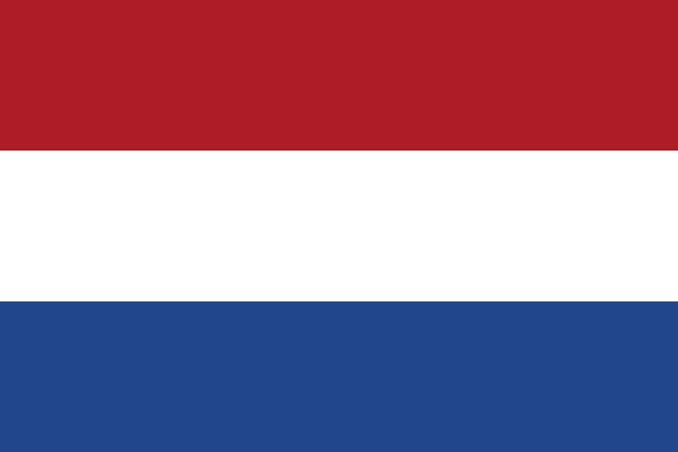
</center>

* A famous problem formulated by Edsger Dijkstra.
* Given a list with colours red, white and blue, return a list such that it has all the reds, and then white followed by blue.
  + Essentially a sorting problem.
* We have seen a generate-and-test based `O(N!)` solution. Let's implement an `O(N)` solution using difference lists.

## Using append with normal lists

```prolog
dutch(L,RWB) :- distribute(L,R,W,B), append(W,B,WB), append(R,WB,RWB).
distribute([red|T],[red|Rt],W,B) :- distribute(T,Rt,W,B).
distribute([white|T],R,[white|Wt],B) :- distribute(T,R,Wt,B).
distribute([blue|T],R,W,[blue|Bt]) :- distribute(T,R,W,Bt).
distribute([],[],[],[]).
```

```prolog
?- dutch([red, white, blue, red, white],X).
X = [red, red, white, white, blue].
```

## Using append with difference lists

```prolog
dutch_dl(L,RWB-RWB1) :- distribute_dl(L,R-R1,W-W1,B-B1), 
                        append(W-W1,B-B1,WB-WB1), 
                        append(R-R1,WB-WB1,RWB-RWB1).
distribute_dl([red|T],[red|Rt]-R1,W,B) :- distribute_dl(T,Rt-R1,W,B).
distribute_dl([white|T],R,[white|Wt]-W1,B) :- distribute_dl(T,R,Wt-W1,B).
distribute_dl([blue|T],R,W,[blue|Bt]-B1) :- distribute_dl(T,R,W,Bt-B1).
distribute_dl([],R-R,W-W,B-B).
append(A-B,B-C,A-C).
```

```prolog
?- dutch_dl([red, white, blue, red, white],X).
X = [red, red, white, white, blue|_A]-_A.
```

## Using append with difference lists

```prolog
dutch_dl(L,RWB) :- distribute_dl(L,RWB-WB,WB-B,B-[]).
distribute_dl([red|T],[red|Rt]-R1,W,B) :- distribute_dl(T,Rt-R1,W,B).
distribute_dl([white|T],R,[white|Wt]-W1,B) :- distribute_dl(T,R,Wt-W1,B).
distribute_dl([blue|T],R,W,[blue|Bt]-B1) :- distribute_dl(T,R,W,Bt-B1).
distribute_dl([],R-R,W-W,B-B).
```

```prolog
?- dutch_dl([red, white, blue, red, white],X).
X = [red, red, white, white, blue].
```

## The End

* We have not covered a few advanced features in both OCaml and Prolog.
 + Monads, GADTs in OCaml
 + Database programming, Constraint Logic Programming in Prolog
* Endsem is on November 23, 9 AM.
 + Most likely same seating arrangements as Quizzes; to be confirmed later.
* Syllabus will be the entire course contents.
 + Closed book, but you can bring 1 A4 sized sheet.
* Some practice problems on Prolog will be released this week. 